In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl import simulate
from tf_rl.models import MLP, Layer, base_name

from __future__ import print_function

In [6]:
from tf_rl.simulation.manipulation import GameObject, Simulation, HeroSimulation, objects_colliding

In [7]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmp6on7dctn


In [8]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from collections import defaultdict
from euclid import Circle, Point2, Vector2, LineSegment2
from itertools import combinations

import tf_rl.utils.svg as svg


class ConvSimulation(Simulation):
    def __init__(self, settings):
        super(ConvSimulation, self).__init__(settings)
        self.hero = GameObject(Point2(0.5,0.5), Vector2(1.0,0.0), "hero", radius=self.settings['obj_radius'])
        self.add(self.hero)
        self.observation_res  = self.settings["observation_resolution"]
        self.observation_size = [self.observation_res, self.observation_res, len(self.settings["observable_objects"]) + 2]
        
    def observe(self):
        observ_obj = self.settings["observable_objects"]
        no = len(observ_obj)
        observation = np.zeros((self.observation_res, self.observation_res, no + 2))
        def rescale(i):
            return min(self.observation_res - 1, max(0, int(round(self.observation_res * i))))
        
        for obj in self.objects:
            cx, cy = rescale(obj.position.x), rescale(obj.position.y)
            sx, ex = obj.position.x - obj.radius, obj.position.x + obj.radius
            sy, ey = obj.position.y - obj.radius, obj.position.y + obj.radius
            sx, ex, sy, ey = [ rescale(i) for i in [sx,ex,sy,ey]]
            layer = observ_obj.index(obj.obj_type)
            for x in range(sx, ex + 1):
                for y in range(sy, ey + 1):
                    if (x-cx)**2 + (y-cy)**2 <= (obj.radius*self.observation_res)**2:
                        observation[x,y,layer]  = 1.0
                        observation[x,y,no]     = obj.speed.x
                        observation[x,y,no + 1] = obj.speed.y
        return observation

In [128]:
class ConvManipulation(ConvSimulation):
    def __init__(self, settings):
        super(ConvManipulation, self).__init__(settings)
        self.actions = [Vector2(*a) for a in self.settings["action_acc"]]
        self.num_actions = len(self.actions)
        
        
        
        self.target     = GameObject(Point2(0, 0), Vector2(0,0), "red", mass=50.0, radius=self.settings['obj_radius'])
        self.randomize_position(self.target, margin=2 * self.settings['obj_radius']) 
        self.add(self.target)

        self.tool     = GameObject(Point2(0, 0), Vector2(0,0), "blue", mass=2.0, radius=self.settings['obj_radius'])
        self.randomize_position(self.tool, margin=2 * self.settings['obj_radius'])
        self.add(self.tool)
        
        self.randomize_position(self.hero)
        
        self.prev_distance = self.distance_to_minimize()
        
    def distance_to_minimize(self):
        return self.tool.position.distance(self.target.position)

    def randomize_position(self, obj, noncoliding=True, margin=0.0):
        gen = lambda: random.uniform(obj.radius + margin, 1.0 - obj.radius - margin)
        obj.position = Point2(gen(), gen())
                
        while noncoliding and any(objects_colliding(obj, other) for other in self.objects if other is not obj):
            obj.position = Point2(gen(), gen())
                                         
    def perform_action(self, action):
        if self.settings["action_type"] == 'speed':
            self.hero.speed = self.actions[action]
        elif self.settings["action_type"] == 'acceleration':
            self.hero.speed += self.actions[action]

    def collect_reward(self):
        new_distance = self.distance_to_minimize()
        delta = self.prev_distance - new_distance 
        self.prev_distance = new_distance
        return 10.0*delta
    
    def success(self):
#         return self.distance_to_minimize() < (self.hero.radius + self.target.radius) * 2
        return self.tool.position.distance(self.target.position) < (self.target.radius + self.tool.radius) * 1.5
    
    def to_html(self, stats=[]):
        stats = stats[:]
        stats.extend([
            "reward = %.3f" % (self.collect_reward()),
        ])
        return super(ConvManipulation, self).to_html(stats=stats)

In [129]:
SETTINGS = {
    'size': 500,
    'colors': {
        'hero': 'yellow',
        'red':  'red',
        'blue': 'blue'
    },
    'restitution': 0.9,
    'observation_resolution': 48,
    'observable_objects': [
        'red',
        'blue',
        'hero',
    ],
    'action_type': 'speed',
    'action_acc': [
        [0.0,   0.0],    # stay still
        
        [-0.05, 0.0],    # left
        [0.05,  0.0],    # right
        [0.0,   -0.05],  # up
        [0.0,   0.05],   # down
        
        [-0.5, 0.0],    # left fast
        [0.5,  0.0],    # right fast
        [0.0,   -0.5],  # up fast
        [0.0,   0.5],   # down fast
    ],
    'obj_radius': 0.07,
    'viscosity': 0.97,
}

g = ConvManipulation(SETTINGS)

In [130]:
# o = g.observe()
# print(o.shape)
# plt.matshow(o[:,:,0].T)
# plt.matshow(o[:,:,1].T)
# plt.matshow(o[:,:,2].T)

# g.to_html()

In [131]:
class ConvLayer(object):
    def __init__(self, filter_H, filter_W, in_C, out_C, nonlinearity=tf.nn.relu, stride=(1,1), scope="Convolution"):
        self.filter_H, self.filter_W, self.in_C, self.out_C = filter_H, filter_W, in_C, out_C
        self.stride       = stride
        self.nonlinearity = nonlinearity
        self.scope        = scope

        with tf.variable_scope(self.scope):
            input_size = filter_H * filter_W * in_C
            W_initializer =  tf.random_uniform_initializer(
                        -1.0 / math.sqrt(input_size), 1.0 / math.sqrt(input_size))
            self.W = tf.get_variable('W', (filter_H, filter_W, in_C, out_C), initializer=W_initializer)
            self.b = tf.get_variable('b', (out_C), initializer=tf.constant_initializer(0))
    
    def __call__(self, X):
        with tf.variable_scope(self.scope):
            return self.nonlinearity(tf.nn.conv2d(X, self.W,  strides=[1] + list(self.stride) + [1], padding='SAME')
                                     + self.b)
        
    def variables(self):
        return [self.b, self.W]

    def copy(self, scope=None):
        scope = scope or self.scope + "_copy"

        with tf.variable_scope(scope) as sc:
            for v in self.variables():
                tf.get_variable(base_name(v), v.get_shape(),
                        initializer=lambda x,dtype=tf.float32: v.initialized_value())
            sc.reuse_variables()
            return ConvLayer(self.filter_H, self.filter_W, self.in_C, self.out_C,
                             nonlinearity=self.nonlinearity, stride=self.stride, scope=sc)

In [132]:
from types import FunctionType

class SequenceWrapper(object):
    def __init__(self, seq, scope=None):
        self.seq   = seq
        self.scope = scope or "MLP"

    def __call__(self, x):
        with tf.variable_scope(self.scope):
            for el in self.seq:
                x = el(x)
            return x
            
    def variables(self):
        res = []
        for el in self.seq:
            if hasattr(el, 'variables'):
                res.extend(el.variables())
        return res
            
    def copy(self, scope=None):
        scope = scope or self.scope + "_copy"
        new_seq = [el if type(el) is FunctionType else el.copy() for el in self.seq ]
        
        return SequenceWrapper(new_seq)

In [144]:
# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.ops.reset_default_graph()
if 'session' in globals():
    session.close()
session = tf.InteractiveSession()

In [145]:
assert g.observation_size[:2] == [48, 48]
in_channels = g.observation_size[2]

convnet = SequenceWrapper([
    # (BATCH, 48, 48, in_channels)
    ConvLayer(4, 4, in_channels,   5,  stride=(2,2), scope="conv0"),
    # (BATCH, 24, 24, 5)        
    ConvLayer(4, 4, 5,  10,  stride=(2,2), scope="conv1"),
    # (BATCH, 12, 12, 10)        
    ConvLayer(4, 4, 10, 20,  stride=(2,2), scope="conv2"),
    # (BATCH, 6, 6, 20)
    ConvLayer(4, 4, 20, 40,  stride=(2,2), scope="conv3"),
    # (BATCH, 3, 3, 40)
    lambda x: tf.reshape(x, (-1, 40 * 3 * 3)),
    # (BATCH, 3 * 3* 40)
    Layer(40 * 3 * 3, g.num_actions, scope="final_project"),
    # (BATCH, g.num_actions)
])

In [146]:
[v.name for v in convnet.variables()]

['conv0/b:0',
 'conv0/W:0',
 'conv1/b:0',
 'conv1/W:0',
 'conv2/b:0',
 'conv2/W:0',
 'conv3/b:0',
 'conv3/W:0',
 'final_project/b:0',
 'final_project/W_0:0']

In [147]:
# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
brain = convnet

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = DiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                   discount_rate=0.9, exploration_period=30000, max_experience=30000, 
                                   store_every_nth=4, train_every_nth=2,
                                   target_network_update_rate=0.01,
                                   summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
# graph was not available when journalist was created  
journalist.add_graph(session.graph_def)

In [148]:
results = []

In [149]:
FPS          = 30
ACTION_EVERY = 3
SIM_TIME     = 10
    
fast_mode = True
training  = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 100
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    while True:
        g = ConvManipulation(SETTINGS)
        simulate(simulation=g,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 training=training,
                 max_frames=SIM_TIME * FPS,
                 save_path=None)
        results.append(1 if g.success() else 0)
except KeyboardInterrupt:
    print("Interrupted")

Interrupted


[ 0.1271642   0.15027322]


(0.0, 1.0)

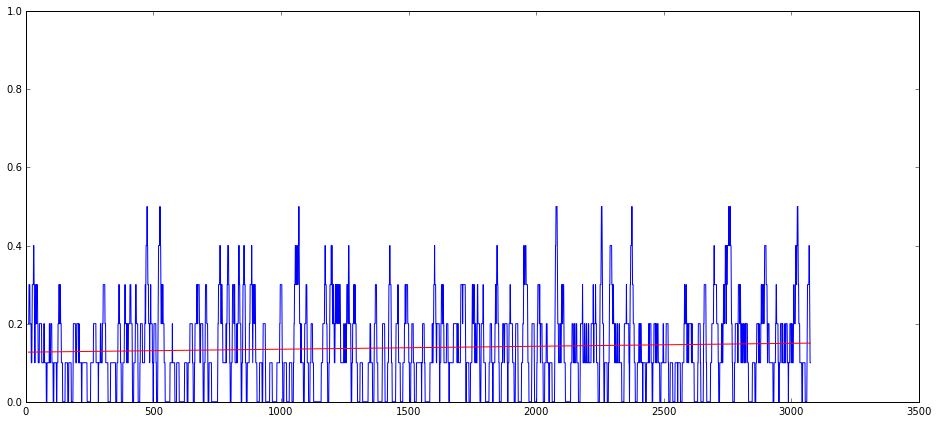

In [140]:
SMOOTHING=10
x = range(SMOOTHING, len(results))
y = [sum(results[i-SMOOTHING:i]) / SMOOTHING for i in x]
f = plt.figure(figsize=(16,7))
plt.plot(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(p([SMOOTHING, len(results)]))
plt.plot(x,p(x),color="red")
plt.gca().set_ylim([0.0, 1.0])

In [124]:
import time
from IPython.display import display, clear_output

try:
    while True:
        g.step(0.03)
        time.sleep(0.03)
        clear_output(wait=True)
        display(g.to_html())
except KeyboardInterrupt:
    print('Interrupted')

Interrupted


In [6]:
m.__class__ = HeroSimulation
print(m.observe().reshape(SETTINGS["num_observation_lines"], len(SETTINGS["observable_objects"]) + 4))
m.to_html()

[[ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 0.43181894  1.         -0.05574019  0.19108082 -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.          0.          0.         -0.15866083 -0.0310832 ]
 [ 1.          1.        